In [15]:
# loading in and transforming data
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,ConcatDataset
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#from skimage import io, transform
from PIL import Image

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

# load dataset information
import yaml

# image writing
import imageio
from skimage import img_as_ubyte

# Clear GPU cache
torch.cuda.empty_cache()

In [16]:
# configuration
datasetTrain = ['a_and_Nc','adenoma','hp_and_nc','hyperplastic_polyp','Normal_colonic_mucosa']
datasetTest = ['a_and_Nc','adenoma','hp_and_nc','hyperplastic_polyp','Normal_colonic_mucosa']

_model_name = 'ESFP_B4_Endo'
config = open('Configure1.yaml')
config = yaml.safe_load(config)
model_type = 'B4'

repeats = 2
n_epochs = 200
init_trainsize = 352
batch_size = 8

In [17]:
class PolypDataset(Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_root, gt_root, trainsize, augmentations):
        self.trainsize = trainsize
        self.augmentations = augmentations

        #图像数据
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg') or f.endswith('.png')]
        #print(image_root)
        #label数据
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.png') or f.endswith('.jpg')]
        
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.filter_files()
        #统计图像数量
        self.size = len(self.images)
        
        if self.augmentations == True:
            print('Using RandomRotation, RandomFlip')
            self.img_transform = transforms.Compose([
                transforms.RandomRotation(90, expand=False, center=None),#在[-90, 90]的范围内随机旋转图像。
                transforms.RandomVerticalFlip(p=0.5),#以50%的概率随机垂直翻转图像
                transforms.RandomHorizontalFlip(p=0.5),#以50%的概率随机水平翻转图像。
                transforms.Resize((self.trainsize, self.trainsize)),#调整图像大小为指定大小，即训练时图像的尺寸。
                #  352*352*3
                transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0, hue=0),#随机调整图像亮度、对比度和饱和度。
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])#对图像进行标准化，使其每个通道的均值为0.485、0.456、0.406，
                                                             #标准差为0.229、0.224、0.225
            self.gt_transform = transforms.Compose([
                transforms.RandomRotation(90, expand=False, center=None),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
            
        else:
            print('no augmentation')
            self.img_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])
            
            self.gt_transform = transforms.Compose([
                transforms.Resize((self.trainsize, self.trainsize)),
                transforms.ToTensor()])
            

    def __getitem__(self, index):
        
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        np.random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.img_transform is not None:
            image = self.img_transform(image)
            
        np.random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.gt_transform is not None:
            gt = self.gt_transform(gt)
        return image, gt

    def filter_files(self):   #确保 self.images 和 self.gts 的长度相等
                            #并且将不匹配尺寸的图像和二进制标签从列表中移除。
        assert len(self.images) == len(self.gts)
        images = []
        gts = []
        for img_path, gt_path in zip(self.images, self.gts):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
        self.images = images
        self.gts = gts                    

    def rgb_loader(self, path):   #用于加载图像文件并将其转换为 RGB 模式。
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path): #用于加载二进制标签文件，并将其转换为灰度图像
        with open(path, 'rb') as f:
            img = Image.open(f)
            # return img.convert('1')
            return img.convert('L')

    def resize(self, img, gt):  #将图片和mask同时设置到最大的尺寸
        assert img.size == gt.size
        w, h = img.size
        if h < self.trainsize or w < self.trainsize:
            h = max(h, self.trainsize)
            w = max(w, self.trainsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def __len__(self):
        return self.size

class test_dataset:
    def __init__(self, image_root, gt_root, testsize):
        self.testsize = testsize
        self.images = [image_root + f for f in os.listdir(image_root) if f.endswith('.jpg') or f.endswith('.png')]
        self.gts = [gt_root + f for f in os.listdir(gt_root) if f.endswith('.tif') or f.endswith('.png') or f.endswith('.jpg')]
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.transform = transforms.Compose([
            transforms.Resize((self.testsize, self.testsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.ToTensor()
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.rgb_loader(self.images[self.index])
        #然后使用 unsqueeze(0) 方法在第 0 维度上增加一个维度
        #将图像转换为形状为 (1, C, H, W) 的张量
        image = self.transform(image).unsqueeze(0) 
        gt = self.binary_loader(self.gts[self.index])
        name = self.images[self.index].split('/')[-1]
        if name.endswith('.jpg'):
            name = name.split('.jpg')[0] + '.png'   #如果图像文件名以 .jpg 结尾，则将其替换为 .png。
        self.index += 1
        return image, gt, name

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')

# 创建训练数据dataset dataloader

In [18]:
trainDatasetList = []
for train_id in datasetTrain:
    images_train_path = config['dataset']['train_' + str(train_id) + '_dataset'] + '/image/'
    masks_train_path = config['dataset']['train_' + str(train_id) + '_dataset'] + '/label/'
    trainDataset = PolypDataset(images_train_path, masks_train_path, trainsize=init_trainsize, augmentations = True)
    trainDatasetList.append(trainDataset)
    

trainWholeDataset = ConcatDataset([trainDatasetList[0], trainDatasetList[1],trainDatasetList[2],trainDatasetList[3],trainDatasetList[4]])
train_loader = DataLoader(dataset=trainDataset,batch_size=batch_size,shuffle=True)

Using RandomRotation, RandomFlip
Using RandomRotation, RandomFlip
Using RandomRotation, RandomFlip
Using RandomRotation, RandomFlip
Using RandomRotation, RandomFlip


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


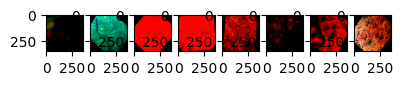

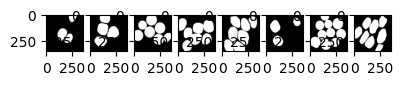

<Figure size 640x480 with 0 Axes>

In [19]:
# imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# set rows and columns
rows = 1
columns = 16

dataiter = iter(train_loader)
# the "_" is a placeholder for no labels
images, masks= next(dataiter)

# show images
fig = plt.figure(figsize=(9,5))
for i in range(1,9):
    fig.add_subplot(rows,columns,i)
    imshow(torchvision.utils.make_grid(images[i-1,:,:,:]))
    
# show images
fig = plt.figure(figsize=(9,5))
for i in range(1,9):
    fig.add_subplot(rows,columns,i)
    imshow(torchvision.utils.make_grid(masks[i-1,:,:,:]))
    
fig = plt.figure()   
#plt.hist(masks.reshape(720*720*5).detach().numpy())

In [20]:
from Encoder import mit
from Decoder import mlp
from mmcv.cnn import ConvModule

class ESFPNetStructure(nn.Module):

    def __init__(self, embedding_dim = 160):
        super(ESFPNetStructure, self).__init__()
        
        # Backbone
        if model_type == 'B0':
            self.backbone = mit.mit_b0()
        if model_type == 'B1':
            self.backbone = mit.mit_b1()
        if model_type == 'B2':
            self.backbone = mit.mit_b2()
        if model_type == 'B3':
            self.backbone = mit.mit_b3()
        if model_type == 'B4':
            self.backbone = mit.mit_b4()
        if model_type == 'B5':
            self.backbone = mit.mit_b5()
        
        self._init_weights()  # load pretrain
        
        # LP Header
        self.LP_1 = mlp.LP(input_dim = self.backbone.embed_dims[0], embed_dim = self.backbone.embed_dims[0])
        self.LP_2 = mlp.LP(input_dim = self.backbone.embed_dims[1], embed_dim = self.backbone.embed_dims[1])
        self.LP_3 = mlp.LP(input_dim = self.backbone.embed_dims[2], embed_dim = self.backbone.embed_dims[2])
        self.LP_4 = mlp.LP(input_dim = self.backbone.embed_dims[3], embed_dim = self.backbone.embed_dims[3])
        
        # Linear Fuse
        self.linear_fuse34 = ConvModule(in_channels=(self.backbone.embed_dims[2] + self.backbone.embed_dims[3]), out_channels=self.backbone.embed_dims[2], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        self.linear_fuse23 = ConvModule(in_channels=(self.backbone.embed_dims[1] + self.backbone.embed_dims[2]), out_channels=self.backbone.embed_dims[1], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        self.linear_fuse12 = ConvModule(in_channels=(self.backbone.embed_dims[0] + self.backbone.embed_dims[1]), out_channels=self.backbone.embed_dims[0], kernel_size=1,norm_cfg=dict(type='BN', requires_grad=True))
        
        # Fused LP Header
        self.LP_12 = mlp.LP(input_dim = self.backbone.embed_dims[0], embed_dim = self.backbone.embed_dims[0])
        self.LP_23 = mlp.LP(input_dim = self.backbone.embed_dims[1], embed_dim = self.backbone.embed_dims[1])
        self.LP_34 = mlp.LP(input_dim = self.backbone.embed_dims[2], embed_dim = self.backbone.embed_dims[2])
        
        # Final Linear Prediction
        self.linear_pred = nn.Conv2d((self.backbone.embed_dims[0] + self.backbone.embed_dims[1] + self.backbone.embed_dims[2] + self.backbone.embed_dims[3]), 1, kernel_size=1)
        
    def _init_weights(self):
        
        if model_type == 'B0':
            pretrained_dict = torch.load('./Pretrained/mit_b0.pth')
        if model_type == 'B1':
            pretrained_dict = torch.load('./Pretrained/mit_b1.pth')
        if model_type == 'B2':
            pretrained_dict = torch.load('./Pretrained/mit_b2.pth')
        if model_type == 'B3':
            pretrained_dict = torch.load('./Pretrained/mit_b3.pth')
        if model_type == 'B4':
            pretrained_dict = torch.load('./Pretrained/mit_b4.pth')
        if model_type == 'B5':
            pretrained_dict = torch.load('./Pretrained/mit_b5.pth')
            
            
        model_dict = self.backbone.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.backbone.load_state_dict(model_dict)
        print("successfully loaded!!!!")
        
        
    def forward(self, x):
#         这段代码是一个模型的前向传递过程。该模型首先通过backbone网络，
#         对输入的x进行特征提取，得到4个不同分辨率的特征图。
#         然后将这些特征图送入LP Header网络进行处理，融合不同层次的特征。
#         接着通过上采样（interpolation）将处理后的特征图进行恢复到原始输入图像尺寸大小，
#         并最终送入线性预测器（linear_pred）获得输出结果。
        ##################  Go through backbone ###################
        
        B = x.shape[0]
        
        #stage 1
        out_1, H, W = self.backbone.patch_embed1(x)
        for i, blk in enumerate(self.backbone.block1):
            out_1 = blk(out_1, H, W)
        out_1 = self.backbone.norm1(out_1)
        #将输入特征图out_1从形状(Batch_Size, N, W, H)变形为(Batch_Size, H, W, N)
        #其中-1表示自动计算N的值。接着使用permute函数将特征维度N和高宽维度H、W交换位置
        #变成(Batch_Size, N, H, W)的形状
        out_1 = out_1.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[0], 88, 88)
        
        # stage 2
        out_2, H, W = self.backbone.patch_embed2(out_1)
        for i, blk in enumerate(self.backbone.block2):
            out_2 = blk(out_2, H, W)
        out_2 = self.backbone.norm2(out_2)
        out_2 = out_2.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[1], 44, 44)
        
        # stage 3
        out_3, H, W = self.backbone.patch_embed3(out_2)
        for i, blk in enumerate(self.backbone.block3):
            out_3 = blk(out_3, H, W)
        out_3 = self.backbone.norm3(out_3)
        out_3 = out_3.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[2], 22, 22)
        
        # stage 4
        out_4, H, W = self.backbone.patch_embed4(out_3)
        for i, blk in enumerate(self.backbone.block4):
            out_4 = blk(out_4, H, W)
        out_4 = self.backbone.norm4(out_4)
        out_4 = out_4.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()  #(Batch_Size, self.backbone.embed_dims[3], 11, 11)
        
        # go through LP Header
        lp_1 = self.LP_1(out_1)
        lp_2 = self.LP_2(out_2)  
        lp_3 = self.LP_3(out_3)  
        lp_4 = self.LP_4(out_4)
        
        # linear fuse and go pass LP Header     上采样并拼接
        lp_34 = self.LP_34(self.linear_fuse34(torch.cat([lp_3, F.interpolate(lp_4,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        lp_23 = self.LP_23(self.linear_fuse23(torch.cat([lp_2, F.interpolate(lp_34,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        lp_12 = self.LP_12(self.linear_fuse12(torch.cat([lp_1, F.interpolate(lp_23,scale_factor=2,mode='bilinear', align_corners=False)], dim=1)))
        
        # get the final output
        lp4_resized = F.interpolate(lp_4,scale_factor=8,mode='bilinear', align_corners=False)
        lp3_resized = F.interpolate(lp_34,scale_factor=4,mode='bilinear', align_corners=False)
        lp2_resized = F.interpolate(lp_23,scale_factor=2,mode='bilinear', align_corners=False)
        lp1_resized = lp_12
        
        out = self.linear_pred(torch.cat([lp1_resized, lp2_resized, lp3_resized, lp4_resized], dim=1))
        out_resized = F.interpolate(out,scale_factor=4,mode='bilinear', align_corners=True)
        
        return out_resized

In [21]:
def ange_structure_loss(pred, mask, smooth=1):
    
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=15, stride=1, padding=7) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduction='mean')
    wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + smooth)/(union - inter + smooth)
    
    return (wbce + wiou).mean()

def dice_loss_coff(pred, target, smooth = 0.0001):
    
    num = target.size(0)
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return loss.sum()/num

In [22]:
from torch.autograd import Variable

def evaluate(): 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ESFPNet.eval()
    val = 0
    dataset_count = 0
    datasetValidation = []
    smooth = 1e-4
    for _data_name in datasetTest:
        test_loader = test_dataset(config['dataset']['test_' + str(_data_name) + '_img'], config['dataset']['test_' + str(_data_name) + '_label'], 352)
        Thresholds = np.linspace(1, 0, 256)   #等差数列
        count = 0
        total_meanDic = 0
            
        for i in range(test_loader.size):
            image, gt, name = test_loader.load_data()
            gt = np.asarray(gt, np.float32)
            gt /= (gt.max() + 1e-8)   #归一化
            target = np.array(gt)

            image = image.cuda()
            
            pred = ESFPNet(image)
            # print("before upsample evaluate--output 的 形状是{}".format(pred.shape))     torch.Size([1, 1, 352, 352])
            pred = F.upsample(pred, size=gt.shape, mode='bilinear', align_corners=False)
    
            pred = pred.sigmoid()
            threshold = torch.tensor([0.5]).to(device)
            pred = (pred > threshold).float() * 1
            pred = pred.data.cpu().numpy().squeeze()
            pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)

            input_flat = np.reshape(pred,(-1))    #扁平化为一维数组
            target_flat = np.reshape(target,(-1))  #扁平化为一维数组
 
            intersection = (input_flat*target_flat)
        
        
            # 进行dice  的计算  下面的loss 其实是dice
            loss =  (2 * intersection.sum() + smooth) / (pred.sum() + target.sum() + smooth)

            Dice =  '{:.4f}'.format(loss)
            Dice = float(Dice)
            total_meanDic = total_meanDic + Dice
            count = count + 1
        datasetValidation.append(total_meanDic/count)
        val = val + total_meanDic/count
        dataset_count = dataset_count + 1
        
    ESFPNet.train()
    
    return val/dataset_count, datasetValidation

In [23]:
# train the network
def training_loop(dataloader_X, n_epochs, coeff_max_global, datasetValidation_max, ESFPNet_optimizer, numIters):
    
    # keep track of losses over time
    losses = []
    coeff_max = 0;
    
    validation_coeff, datasetValidation = evaluate();
    if coeff_max<validation_coeff:
        coeff_max = validation_coeff
    
    # set up data and then train
    iter_X = iter(dataloader_X)
    steps_per_epoch = len(iter_X)
    num_epoch = 0
    total_steps = (n_epochs+1)*steps_per_epoch
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for step in range(1, total_steps):

        # Reset iterators for each epoch
        if step % steps_per_epoch == 0:
            iter_X = iter(dataloader_X)
            num_epoch = num_epoch + 1
        
        # make sure to scale to a range -1 to 1
        images, masks = next(iter_X)
        
        # move images to GPU if available (otherwise stay on CPU)
        images = images.to(device)
        masks = masks.to(device)


        # ============================================
        #            TRAIN THE NETWORKS
        # ============================================
       
        ESFPNet_optimizer.zero_grad()
        
        # 1. Compute the losses from the network
        
        out = ESFPNet(images)
        loss = ange_structure_loss(out, masks)
        
        loss.backward()
        
        ESFPNet_optimizer.step() 
        
        # ============================================
        #            TRAIN THE NETWORKS
        # ============================================
        # Print the log info
        
        if step % steps_per_epoch == 0:
            losses.append(loss.item())
            print('Epoch [{:5d}/{:5d}] | preliminary loss: {:6.6f} '.format(num_epoch, n_epochs, loss.item()))
            
        if step % steps_per_epoch == 0:
            
            validation_coeff, datasetValidation = evaluate()
            print('Epoch [{:5d}/{:5d}] | validation_coeffient: {:6.6f} '.format(
                    num_epoch, n_epochs, validation_coeff))
            
            if coeff_max < validation_coeff:
                coeff_max = validation_coeff
            
            if coeff_max_global < validation_coeff:
                coeff_max_global = validation_coeff
                save_model_path = './SaveModel/{}_AverageOptimize_{:1d}'.format(_model_name,numIters)
                os.makedirs(save_model_path, exist_ok=True)
                torch.save(ESFPNet, save_model_path + '/ESFPNet.pt')
                print('Save Average Optimized Model at Epoch [{:5d}/{:5d}]'.format(num_epoch, n_epochs))
            
            count_dataset = 0
            for _data_name in datasetTest:
                if datasetValidation_max[count_dataset]<datasetValidation[count_dataset]:
                    datasetValidation_max[count_dataset]=datasetValidation[count_dataset]
                    save_model_path = './SaveModel/{}_DatasetBest_{:1d}/{}'.format(_model_name,numIters,_data_name)
                    os.makedirs(save_model_path, exist_ok=True)
                    torch.save(ESFPNet, save_model_path + '/ESFPNet.pt')
                    print('Save Optimized {} Model at Epoch [{:5d}/{:5d}, with coefficient: {:6.6f}]'.format(_data_name, num_epoch, n_epochs, datasetValidation[count_dataset]))
                count_dataset = count_dataset + 1
                
            
    return losses, coeff_max_global, datasetValidation_max

In [24]:
def saveResult(numIters):
    for _data_name in datasetTest:
    
        save_path = './results/{}_DatasetBest_{:1d}/{}/'.format(_model_name,numIters,_data_name)
        os.makedirs(save_path, exist_ok=True)
        
        test_loader = test_dataset(config['dataset']['test_' + str(_data_name) + '_img'], config['dataset']['test_' + str(_data_name) + '_label'], 352)
    
        model_path = './SaveModel/{}_DatasetBest_{:1d}/{}'.format(_model_name,numIters,_data_name)
        ESFPNetBest = torch.load(model_path + '/ESFPNet.pt')
        ESFPNetBest.eval()

        for i in range(test_loader.size):
            image, gt, name = test_loader.load_data()
            gt = np.asarray(gt, np.float32)
            gt /= (gt.max() + 1e-8)
            image = image.cuda()

            pred = ESFPNetBest(image)
            pred = F.upsample(pred, size=gt.shape, mode='bilinear', align_corners=False)
            pred = pred.sigmoid()
            threshold = torch.tensor([0.5]).to(device)
            pred = (pred > threshold).float() * 1
            pred = pred.data.cpu().numpy().squeeze()
            pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        
            imageio.imwrite(save_path+name,img_as_ubyte(pred))

    for _data_name in datasetTest:
    
        save_path = './results/{}_AverageOptimal_{:1d}/{}/'.format(_model_name,numIters,_data_name)
        os.makedirs(save_path, exist_ok=True)
        
        test_loader = test_dataset(config['dataset']['test_' + str(_data_name) + '_img'], config['dataset']['test_' + str(_data_name) + '_label'], 352)
    
        model_path = './SaveModel/{}_AverageOptimize_{:1d}'.format(_model_name,numIters)
        ESFPNetBest = torch.load(model_path + '/ESFPNet.pt')
        ESFPNetBest.eval()

        for i in range(test_loader.size):
            image, gt, name = test_loader.load_data()
            gt = np.asarray(gt, np.float32)
            gt /= (gt.max() + 1e-8)
            image = image.cuda()

            pred = ESFPNetBest(image)
            pred = F.upsample(pred, size=gt.shape, mode='bilinear', align_corners=False)
            pred = pred.sigmoid()
            threshold = torch.tensor([0.5]).to(device)
            pred = (pred > threshold).float() * 1
            pred = pred.data.cpu().numpy().squeeze()
            pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        
            imageio.imwrite(save_path+name,img_as_ubyte(pred))

#####################################################################################
[    1/    2]
successfully loaded!!!!
Models moved to GPU.
#####################################################################################


D:\Anaconda3\envs\meproj\lib\site-packages\torch\nn\functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch [    1/  200] | preliminary loss: 0.903528 
Epoch [    1/  200] | validation_coeffient: 0.441690 
Save Average Optimized Model at Epoch [    1/  200]
Save Optimized a_and_Nc Model at Epoch [    1/  200, with coefficient: 0.708350]
Save Optimized adenoma Model at Epoch [    1/  200, with coefficient: 0.294323]
Save Optimized hp_and_nc Model at Epoch [    1/  200, with coefficient: 0.389900]
Save Optimized hyperplastic_polyp Model at Epoch [    1/  200, with coefficient: 0.205581]
Save Optimized Normal_colonic_mucosa Model at Epoch [    1/  200, with coefficient: 0.610296]
Epoch [    2/  200] | preliminary loss: 0.792410 
Epoch [    2/  200] | validation_coeffient: 0.490996 
Save Average Optimized Model at Epoch [    2/  200]
Save Optimized a_and_Nc Model at Epoch [    2/  200, with coefficient: 0.726550]
Save Optimized adenoma Model at Epoch [    2/  200, with coefficient: 0.331142]
Save Optimized hp_and_nc Model at Epoch [    2/  200, with coefficient: 0.477900]
Save Optimized hy

Epoch [   40/  200] | preliminary loss: 0.381884 
Epoch [   40/  200] | validation_coeffient: 0.552532 
Epoch [   41/  200] | preliminary loss: 0.411260 
Epoch [   41/  200] | validation_coeffient: 0.522533 
Epoch [   42/  200] | preliminary loss: 0.373735 
Epoch [   42/  200] | validation_coeffient: 0.607181 
Epoch [   43/  200] | preliminary loss: 0.408831 
Epoch [   43/  200] | validation_coeffient: 0.572880 
Epoch [   44/  200] | preliminary loss: 0.376417 
Epoch [   44/  200] | validation_coeffient: 0.579797 
Save Optimized Normal_colonic_mucosa Model at Epoch [   44/  200, with coefficient: 0.760121]
Epoch [   45/  200] | preliminary loss: 0.429717 
Epoch [   45/  200] | validation_coeffient: 0.583915 
Epoch [   46/  200] | preliminary loss: 0.464263 
Epoch [   46/  200] | validation_coeffient: 0.606250 
Save Optimized adenoma Model at Epoch [   46/  200, with coefficient: 0.472714]
Save Optimized Normal_colonic_mucosa Model at Epoch [   46/  200, with coefficient: 0.761472]
Epoc

Epoch [  109/  200] | preliminary loss: 0.284007 
Epoch [  109/  200] | validation_coeffient: 0.579967 
Epoch [  110/  200] | preliminary loss: 0.293564 
Epoch [  110/  200] | validation_coeffient: 0.573109 
Epoch [  111/  200] | preliminary loss: 0.284834 
Epoch [  111/  200] | validation_coeffient: 0.564837 
Epoch [  112/  200] | preliminary loss: 0.293540 
Epoch [  112/  200] | validation_coeffient: 0.563565 
Epoch [  113/  200] | preliminary loss: 0.277781 
Epoch [  113/  200] | validation_coeffient: 0.572268 
Epoch [  114/  200] | preliminary loss: 0.286303 
Epoch [  114/  200] | validation_coeffient: 0.568739 
Epoch [  115/  200] | preliminary loss: 0.257522 
Epoch [  115/  200] | validation_coeffient: 0.567092 
Epoch [  116/  200] | preliminary loss: 0.272369 
Epoch [  116/  200] | validation_coeffient: 0.561140 
Epoch [  117/  200] | preliminary loss: 0.275037 
Epoch [  117/  200] | validation_coeffient: 0.566291 
Epoch [  118/  200] | preliminary loss: 0.296689 
Epoch [  118/ 

Epoch [  184/  200] | validation_coeffient: 0.575185 
Epoch [  185/  200] | preliminary loss: 0.230371 
Epoch [  185/  200] | validation_coeffient: 0.578944 
Epoch [  186/  200] | preliminary loss: 0.188285 
Epoch [  186/  200] | validation_coeffient: 0.536301 
Epoch [  187/  200] | preliminary loss: 0.203804 
Epoch [  187/  200] | validation_coeffient: 0.579216 
Epoch [  188/  200] | preliminary loss: 0.186690 
Epoch [  188/  200] | validation_coeffient: 0.585766 
Epoch [  189/  200] | preliminary loss: 0.217792 
Epoch [  189/  200] | validation_coeffient: 0.589920 
Epoch [  190/  200] | preliminary loss: 0.190735 
Epoch [  190/  200] | validation_coeffient: 0.581923 
Epoch [  191/  200] | preliminary loss: 0.234083 
Epoch [  191/  200] | validation_coeffient: 0.570814 
Epoch [  192/  200] | preliminary loss: 0.219531 
Epoch [  192/  200] | validation_coeffient: 0.570608 
Epoch [  193/  200] | preliminary loss: 0.198940 
Epoch [  193/  200] | validation_coeffient: 0.569902 
Epoch [  1

KeyboardInterrupt: 

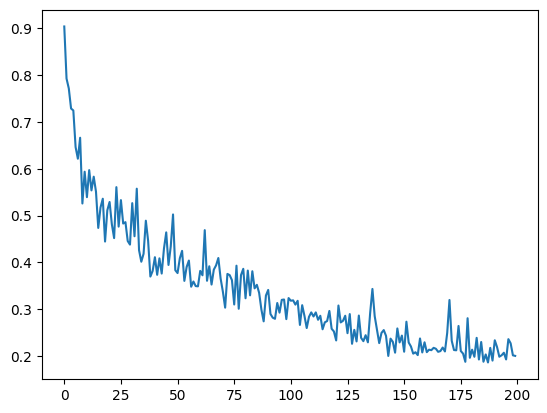

In [25]:
import torch.optim as optim

for i in range(repeats):
    
    coeff_max_global = 0
    datasetValidation_max = [0,0,0,0,0]
    
    print('#####################################################################################')  
    print('[{:5d}/{:5d}]'.format(i+1, repeats))
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    ESFPNet = ESFPNetStructure()
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        ESFPNet.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')
    print('#####################################################################################')  
        
    # hyperparams for Adam optimizer
    lr=0.0001 #0.0001

    ESFPNet_optimizer = optim.AdamW(ESFPNet.parameters(), lr=lr)

    # scheduler_warmup is chained with schduler_steplr
    losses, coeff_max_global, datasetValidation_max = training_loop(train_loader, n_epochs, coeff_max_global, datasetValidation_max, ESFPNet_optimizer, i+1)
    
    plt.plot(losses)
    
    print('#####################################################################################')  
    print('optimize_average_m_dice: {:6.6f}'.format(coeff_max_global))
    #datasetTest = ['a_and_Nc','adenoma','hp_and_nc','hyperplastic_polyp','Normal_colonic_mucosa']
    print('a_and_Nc: {:6.6f} | adenoma: {:6.6f} | hp_and_nc: {:6.6f} | hyperplastic_polyp: {:6.6f} | Normal_colonic_mucosa: {:6.6f}'.format(datasetValidation_max[0],datasetValidation_max[1],datasetValidation_max[2],datasetValidation_max[3],datasetValidation_max[4]))
    print('#####################################################################################')  
    
    saveResult(i+1)
    print('#####################################################################################')  
    print('saved the results')
    print('#####################################################################################')  